# What Factors Affect the Ability of a team to win across games

In [8]:
import pandas as pd
from matplotlib import pyplot as plt
# Make sure you have seaborn version 0.9.
import seaborn as sns

## Max - Average Number of Walks vs. Games Won

In [9]:
teams = pd.read_csv('./data/core/Teams.csv')
teams.columns

walkteams = teams[['BB', 'G', 'W', 'yearID', 'teamID']] 
display(walkteams)
walkteams = walkteams.dropna()
display(walkteams[walkteams.isna().any(axis=1)])
walkteams['balls/game'] = walkteams.BB/walkteams.G
walkteams['winPercent'] = walkteams.W/walkteams.G

,BB,G,W,yearID,teamID
0,60.0,31,20,1871,BS1
1,60.0,28,19,1871,CH1
2,26.0,29,10,1871,CL1
3,33.0,19,7,1871,FW1
4,33.0,33,16,1871,NY2
...,...,...,...,...,...
2860,593.0,162,83,2017,SLN
2861,545.0,162,80,2017,TBA
2862,544.0,162,78,2017,TEX
2863,542.0,162,76,2017,TOR


,BB,G,W,yearID,teamID


<Axes: xlabel='balls/game', ylabel='winPercent'>

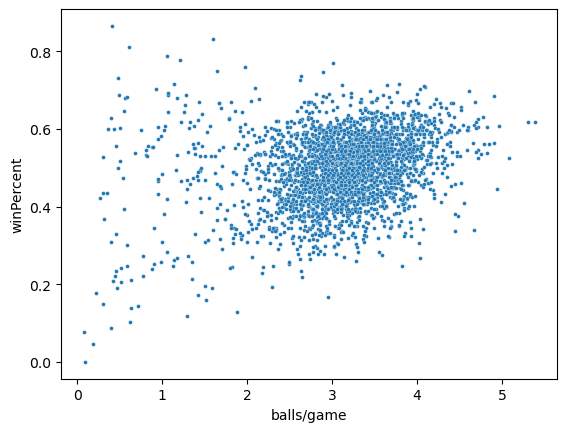

In [10]:
sns.scatterplot(x='balls/game', y='winPercent', data=walkteams, s=8)

## Max Second

In [11]:
teams = pd.read_csv('./data/core/Teams.csv')
teams.columns

stealTeams = teams[['CS', 'SB', 'G', 'W', 'yearID', 'teamID']] 
stealTeams = walkteams.dropna()
stealTeams['stealAttempts'] = walkteams.SB + walkteams.CS
stealTeams['successfulStealAttemptsPercent'] = walkteams.SB/walkteams.stealAttempts

,CS,SB,G,W,yearID,teamID
0,16.0,73.0,31,20,1871,BS1
1,21.0,69.0,28,19,1871,CH1
2,8.0,18.0,29,10,1871,CL1
3,4.0,16.0,19,7,1871,FW1
4,15.0,46.0,33,16,1871,NY2
...,...,...,...,...,...,...
2860,31.0,81.0,162,83,2017,SLN
2861,34.0,88.0,162,80,2017,TBA
2862,44.0,113.0,162,78,2017,TEX
2863,24.0,53.0,162,76,2017,TOR


,CS,SB,G,W,yearID,teamID


AttributeError: 'DataFrame' object has no attribute 'BB'